In [1]:
import os
import torch
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import random
from torch.utils.data import IterableDataset, DataLoader

import datasets
from data_loader import ImageFragmentsDataset
import cluster_metrics
from image_fragmentation_models import LinearImageFragmentModel, ConvulationalImageFragmentModel

2025-09-10 16:11:24.015597: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757520684.024952  163047 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757520684.029454  163047 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757520684.035321  163047 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757520684.035332  163047 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757520684.035334  163047 computation_placer.cc:177] computation placer alr

In [2]:
# MODEL PARAMS THAT DECIDE THE MODEL TO BE USED FOR EVAL
FRAGMENT_SIZE = 16
MODEL_TYPE = 'conv' # 'linear' or 'conv'
FEATURE_DIMENSION = 128
EPOCH_NUM = 5
TRAINED_MODEL_DIR = 'TRAINED_MODEL_DIR'

if MODEL_TYPE == 'linear':
    image_fragment_model = LinearImageFragmentModel(FRAGMENT_SIZE, FEATURE_DIMENSION)
elif MODEL_TYPE == 'conv':
    image_fragment_model = ConvulationalImageFragmentModel(FRAGMENT_SIZE, FEATURE_DIMENSION)
model_file_path = os.path.join(TRAINED_MODEL_DIR,
                               f'image_fragment_model_{MODEL_TYPE}_fd_{FEATURE_DIMENSION}_epoch_{EPOCH_NUM}.pth')
if not os.path.exists(model_file_path):
    print(f"Model file {model_file_path} does not exist. Make sure valid models params are being used.")
state_dict = torch.load(model_file_path)
image_fragment_model.load_state_dict(state_dict)
image_fragment_model.to(torch.device("cpu"))
image_fragment_model.eval()

DS = datasets.Imagenet64Eval('../data/dev_data/dev_data_batch_1')
image_dg = DS.datagen_cls(10)

image_fragments_dataset = ImageFragmentsDataset(image_dg)

all_samples = [sample for sample in image_fragments_dataset]

print(f"Loaded all {len(all_samples)} sample groups")



Finished loading test dataset with 5000 samples


I0000 00:00:1757520685.710832  163047 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 94386 MB memory:  -> device: 0, name: NVIDIA GH200 480GB, pci bus id: 0000:dd:00.0, compute capability: 9.0


Loaded all 500 sample groups


In [3]:
# function to get groupings for a single sample
def get_fragment_groupings(sample, sources):

    # move data to device
    sample = sample.to(torch.device("cpu"))
    # forward pass to get fragment features
    features = image_fragment_model(sample.unsqueeze(dim=0)) # add batch dimension
    kmeans = KMeans(n_clusters=10, random_state=42, n_init='auto')
    cluster_assignments = kmeans.fit_predict(features[0, :].detach().cpu().numpy())
    sample_cluster_metrics = cluster_metrics.compute_pairwise_agreement_metrics(
                sources.detach().cpu().numpy(),
                cluster_assignments)
    # reshape sample for easy plotting of fragments
    #sample = sample.reshape(shape=(sample.shape[0] * sample.shape[1], sample.shape[2]))
    sample = sample.reshape(sample.shape[0], FRAGMENT_SIZE, FRAGMENT_SIZE, 3)
    sample = sample.numpy()
    return sample, cluster_assignments, sample_cluster_metrics



In [4]:
# plots image fragments in a 2d array
def plot_image_fragments(image_fragments):
    num_image_fragments = image_fragments.shape[0]
    N_X = 4
    N_Y = 40
    plt.close('all')
    fig, axes = plt.subplots(N_X, N_Y, figsize=(N_Y * 3, N_X * 3)) # Adjust figsize as needed
    
    for i in range(num_image_fragments):
        row_ind = i % N_X
        col_ind = i // N_X
        ax = axes[row_ind, col_ind]
        ax.imshow(image_fragments[i])
        ax.axis('off') # Hide axes ticks and labels

    plt.tight_layout()
    plt.show()

In [5]:
random_sample = random.choice(all_samples)
sample_image_fragments, cluster_assignments, sample_cluster_metrics = get_fragment_groupings(random_sample[0], random_sample[1])
# Order the fragments based on cluster id
ordered_fragment_indices = np.argsort(cluster_assignments)
ordered_fragments = sample_image_fragments[ordered_fragment_indices]

#### Visualization of image fragments from a random sample

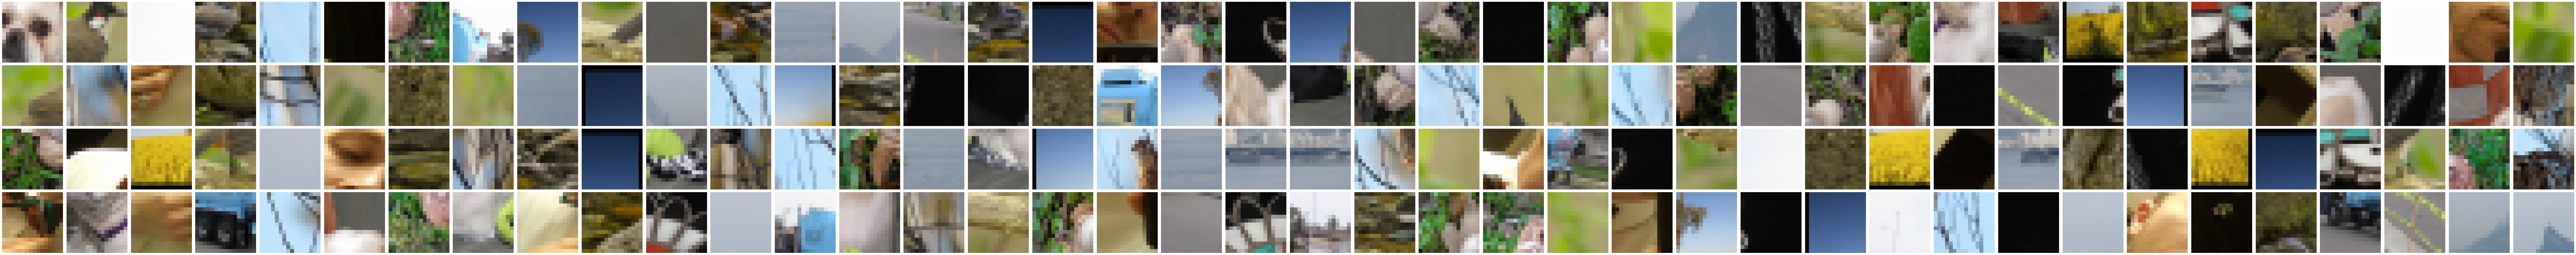

In [6]:
plot_image_fragments(sample_image_fragments)

#### Visualization of image fragments from the same sample ordered by cluster id

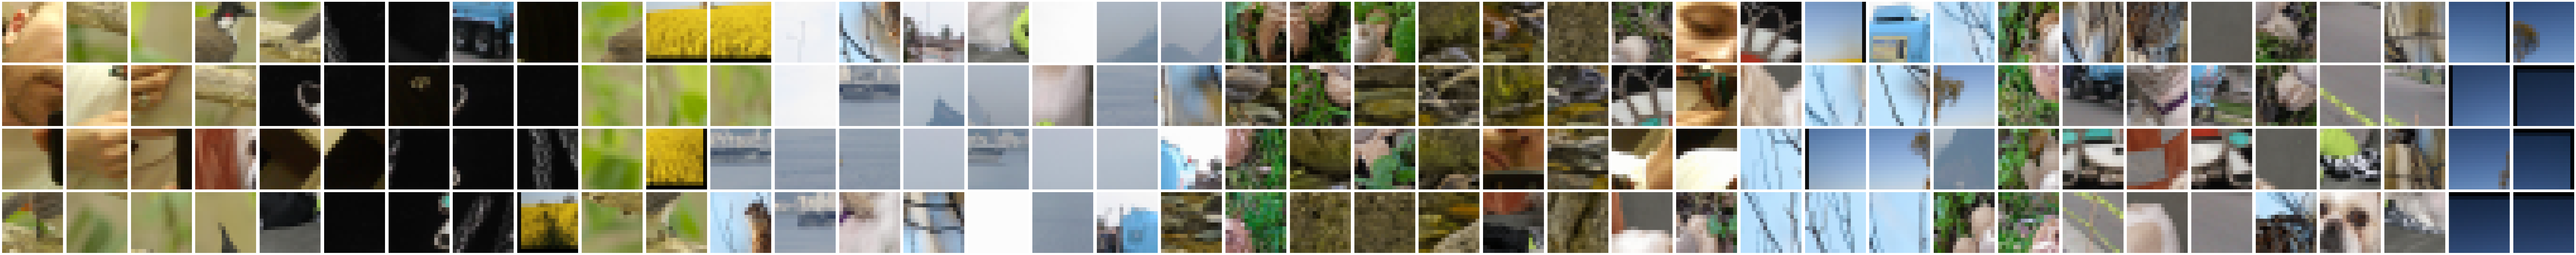

In [7]:
plot_image_fragments(ordered_fragments)

In [8]:
print(sample_cluster_metrics)

{'precision': 0.3813046402151984, 'recall': 0.4725, 'f1_score': 0.42203200595459617, 'true_positive': 567, 'false_positive': 920, 'false_negative': 633, 'true_negative': 10600, 'total_pairs': 12720}
